# Safe Absorbing States

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of Omega-automaton states (including the trap state): 4


C:\Users\ingyh\AppData\Local\Temp/ipykernel_19712/2726659902.py:35: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ],dtype=np.object)


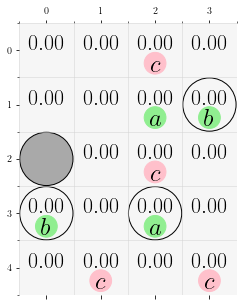

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np 

# LTL Specification
ltl = '(F G a | F G b) & G !c'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('c',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('c',),()],
[('b',),   (),     ('a',),()],
[(),       ('c',), (),    ('c',)]
],dtype=np.object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('c',):'pink'
}
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap,figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)

In [3]:
Q=csrl.q_learning(T=100,K=1000)

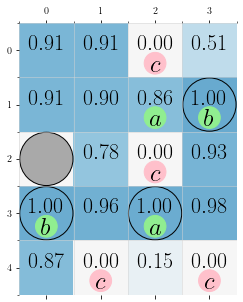

In [4]:
value=np.max(Q,axis=4)
# csrl.plot(value,iq=(0,0),save='safe_absorbing_states_values.pdf')
csrl.plot(value,iq=(0,0))

[[[[2 3 0 1]
   [3 0 2 5]
   [0 0 0 0]
   [5 2 6 0]
   [0 0 0 0]]

  [[0 0 0 0]
   [0 0 0 1]
   [0 0 0 0]
   [1 0 0 0]
   [0 0 0 0]]

  [[0 0 0 0]
   [0 0 1 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 0 0]]

  [[0 0 0 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 0 0]]]]


interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=3), …

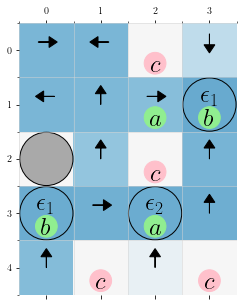

In [5]:
policy=np.argmax(Q,axis=4)
print(policy)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy)

In [ ]:
episode=csrl.simulate(policy,start=(0,0),T=1000)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=2.)
sns.set_style({'font.family': 'Times New Roman'})

# Maximal probabilities
pmax = np.array([
    [1.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 0.8, 1.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 0.8, 0.0]
])

R = 100  # Repetitions
K_max = 18  # Log2 of the maximum episode length 
e = np.zeros((K_max, R))  # Error matrix
for k,K in enumerate(2**np.arange(K_max)):
    for i in range(R):
        Q=csrl.q_learning(T=100,K=K)
        value=np.max(Q,axis=4)
        e[k,i] = np.linalg.norm(value[0,0]-pmax)

mean = np.mean(e,axis=1)
std = np.std(e,axis=1)

# Plot the errors
K_min = 10  #  Log2 of the minimum episode length to be plotted
plt.figure(figsize=(6,6))
plt.errorbar(np.arange(K_min,K_max),mean[K_min:],yerr=std[K_min:],capsize=6,capthick=2,linewidth=3)
plt.xlabel(r'Number of Episodes')
plt.xticks(np.arange(K_min,K_max),['$2^{'+str(i)+'}$' for i in np.arange(K_min,K_max)])
plt.ylabel('L2 Norm of Errors')
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(True)
plt.gca().xaxis.set_label_coords(0.4, -0.14)
plt.gca().set_facecolor('whitesmoke')
# plt.savefig('convergence.pdf',bbox_inches='tight')